In [ ]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from pyathena import connect
import io
from bs4 import BeautifulSoup
from scipy.stats import zscore
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from dotenv import load_dotenv
import os

In [ ]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Data Extraction

## Retrieving European Space Agency (ESA) Data

In [ ]:
load_dotenv()

# API Endpoint
esa_api_url = "https://discosweb.esoc.esa.int/api/objects"

# Your Personal Access Token
token = os.getenv('esa_token')

# Set up authentication headers
headers = {
    "Authorization": f"Bearer {token}",
    "DiscosWeb-Api-Version": "2",
    "Accept": "application/vnd.api+json"
}

# Query Parameters (Retrieving all object attributes)
params = {
    "page[size]": 100,  # Max allowed per page
}

# List to store all object records
all_data = []
page = 1  # Start with page 1

with tqdm(desc="Fetching Data", unit=" records", smoothing=0.1) as pbar:
    while True:
        params["page[number]"] = page  # Set current page number
        response = requests.get(esa_api_url, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            
            if "data" in data and data["data"]:
                all_data.extend(data["data"])  # Store raw data
                pbar.update(len(data["data"]))  # Update progress bar
            else:
                break  # Stop if no more data
            
            page += 1  # Move to next page
        else:
            print(f"❌ Error: {response.status_code}, {response.text}")
            break

# Extract all object attributes
esa_df = pd.DataFrame([obj["attributes"] for obj in all_data])

# Save as Parquet for efficiency
# esa_df.to_parquet("Data to use/full_esa_data.parquet", index=False)

print(f"✅ Retrieved {len(df)} records and saved as Parquet!")

## Scrape Lost Object Data from CelesTrek

In [1]:
# Base URL for lost satellites
base_url = "https://celestrak.org/satcat/lost.php"

# Initialize empty list to store data
all_rows = []

# Fetch the first page to determine pagination
response = requests.get(base_url)
if response.status_code != 200:
    print(f"Failed to retrieve data: {response.status_code}")
else:
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the total number of pages (if pagination exists)
    pagination = soup.find("div", class_="pagination")
    if pagination:
        pages = [a.text for a in pagination.find_all("a") if a.text.isdigit()]
        total_pages = max(map(int, pages)) if pages else 1
    else:
        total_pages = 1  # If no pagination, assume one page

    print(f"Total pages found: {total_pages}")

    # Loop through all pages
    for page in range(1, total_pages + 1):
        print(f"Scraping page {page}...")
        page_url = f"{base_url}?page={page}" if total_pages > 1 else base_url
        response = requests.get(page_url)
        
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}: {response.status_code}")
            continue
        
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find("table")
        
        if table:
            # Extract headers from first page only
            if page == 1:
                headers = [header.text.strip() for header in table.find_all("th")]

            # Extract data rows
            for row in table.find_all("tr")[1:]:  # Skip header row
                cols = [col.text.strip() for col in row.find_all("td")]
                if cols:
                    all_rows.append(cols)

# Convert to DataFrame
lost_object_df = pd.DataFrame(all_rows, columns=headers)

#Ingest to folder
lost_object_df.to_csv("Data to use/lost_objects.csv", index = False)


NameError: name 'requests' is not defined

## Retrieve Low Earth Object data from Space Track

In [ ]:
# Space-Track login credentials
USERNAME = os.getenv('user')
PASSWORD = os.getenv('pass')

# Space-Track API URL for querying LEO satellites (sample query from website)
url = "https://www.space-track.org/basicspacedata/query/class/satcat/PERIOD/<128/DECAY/null-val/CURRENT/Y/"

# Create a session for authentication
session = requests.Session()

# Authenticate with space-track.org
login_url = "https://www.space-track.org/ajaxauth/login"
login_data = {"identity": USERNAME, "password": PASSWORD}
session.post(login_url, data=login_data)

# Fetch JSON data
response = session.get(url)

# Ensure request was successful
if response.status_code == 200:
    json_data = response.json()  # Convert response to JSON format

    # Convert JSON to Pandas DataFrame
    leo_df = pd.DataFrame(json_data)

    #leo_df.to_csv("Data to use/leo_objects.csv", index = False)

else:
    print("Failed to retrieve data. Check credentials or API access.")
    print(response.text)


# Ingest into s3 bucket

In [ ]:
!aws s3 cp "Data to use/full_esa_data.parquet" "s3://{bucket}/data/full_esa_folder/"
!aws s3 cp "Data to use/full_satcat.csv" "s3://{bucket}/data/satcat_folder/"
!aws s3 cp "Data to use/leo_objects.csv" "s3://{bucket}/data/leo_objects_folder/"
!aws s3 cp "Data to use/lost_objects.csv" "s3://{bucket}/data/lost_objects_folder/"
!aws s3 cp "Data to use/simplified_collision_data.csv" "s3://{bucket}/data/simplified_collision_folder/"

# EDA

## Full ESA

In [ ]:
df = pd.read_parquet('Data to use/full_esa_data.parquet')

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vimpelId,14933.0,95640.434943,45331.952486,9600.000000,69211.000000,79106.000000,141218.000000,1.346400e+06
satno,63052.0,31543.718455,18220.717310,1.000000,15766.750000,31534.500000,47302.250000,6.315500e+04
mass,34050.0,1807.384763,7269.503234,0.001500,130.820000,500.000000,1600.000000,4.500000e+05
width,18430.0,2.231862,2.070336,0.000000,0.400000,2.200000,3.700000,7.280000e+01
height,32680.0,3.278075,5.173099,0.001000,0.300000,1.200000,5.500000,6.000000e+01
depth,18403.0,1.888098,2.977385,0.012000,0.500000,1.500000,2.700000,1.085000e+02
diameter,14809.0,2.309130,1.438350,0.001000,1.400000,2.400000,3.000000,4.114000e+01
span,32380.0,9.730365,152.026790,0.020000,1.500000,6.500000,8.990000,1.920000e+04
xSectMax,32980.0,28.481166,101.742724,0.000130,1.375159,16.219661,25.626695,8.319848e+03
xSectMin,32980.0,4.637487,37.008288,0.000000,0.231100,0.810000,4.523893,1.521000e+03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81941 entries, 0 to 81940
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cosparId                    67666 non-null  object 
 1   vimpelId                    14933 non-null  float64
 2   satno                       63052 non-null  float64
 3   name                        67390 non-null  object 
 4   objectClass                 81941 non-null  object 
 5   mass                        34050 non-null  float64
 6   shape                       33235 non-null  object 
 7   width                       18430 non-null  float64
 8   height                      32680 non-null  float64
 9   depth                       18403 non-null  float64
 10  diameter                    14809 non-null  float64
 11  span                        32380 non-null  float64
 12  xSectMax                    32980 non-null  float64
 13  xSectMin                    329

**Can immediately see that some features will need data types changed such as satno or predDecayDate**

**Check outliers**

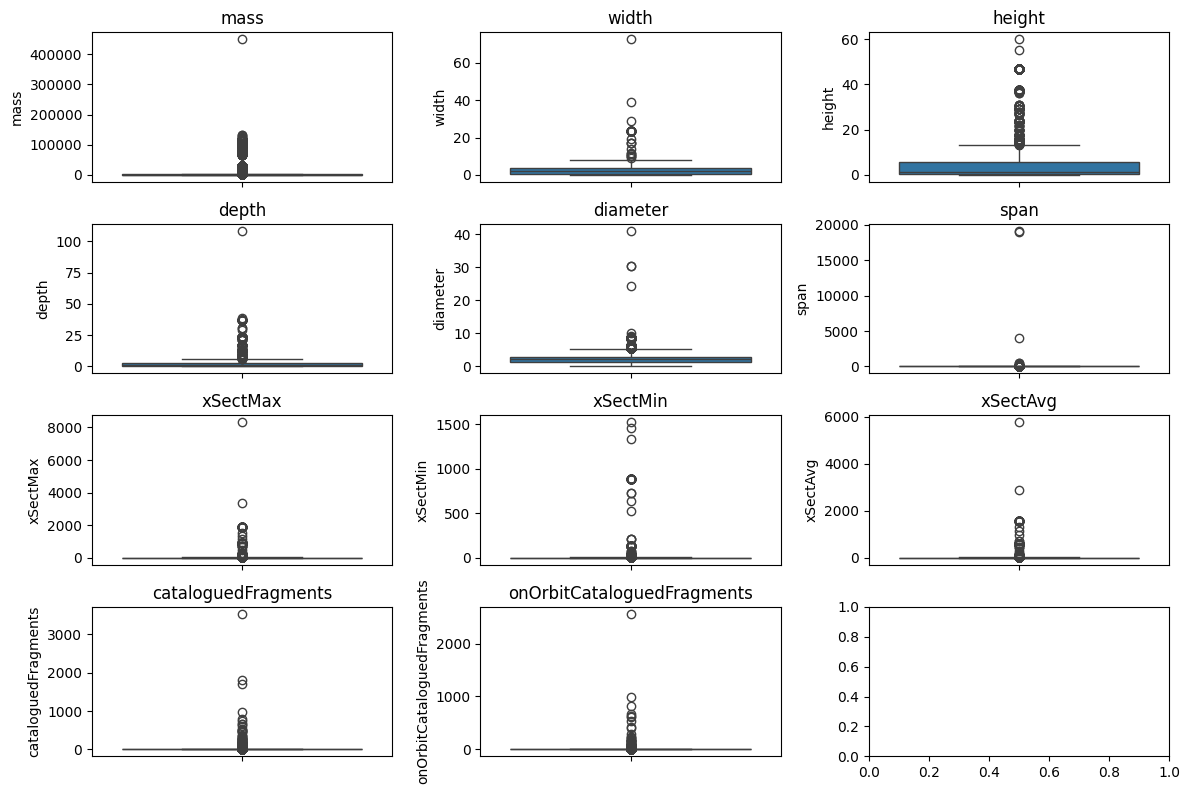

In [ ]:
# Create a list of numeric columns to plot
numeric_cols = ['mass', 'width', 'height', 'depth', 'diameter', 'span', 'xSectMax', 'xSectMin','xSectAvg', 
                'cataloguedFragments', 'onOrbitCataloguedFragments']

# Set up the matplotlib grid
fig, axes = plt.subplots(4, 3, figsize=(12, 8))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


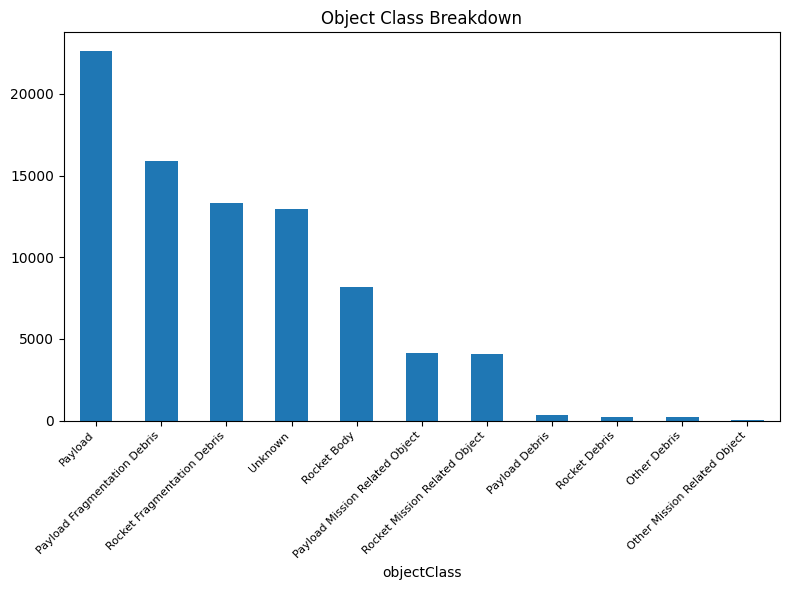

In [61]:
import matplotlib.pyplot as plt
import textwrap

plt.figure(figsize = (8, 6))

ax = df['objectClass'].value_counts().plot(kind='bar', title="Object Class Breakdown")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


<Axes: xlabel='firstEpoch'>

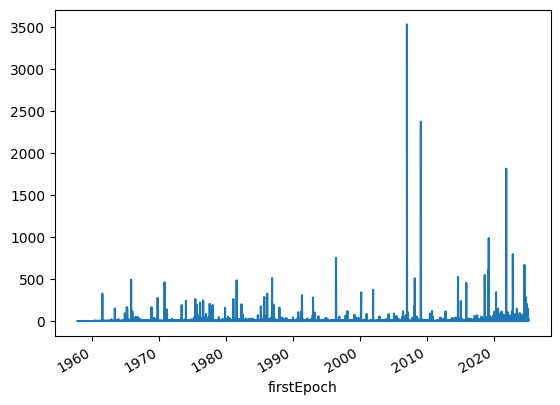

In [40]:
df['firstEpoch'] = pd.to_datetime(df['firstEpoch'])

df['firstEpoch'].value_counts().sort_index().plot(x = 'firstEpoch', kind = 'line')

**Missing Values**

In [23]:
df.isna().sum()

cosparId                      14275
vimpelId                      67008
satno                         18889
name                          14551
objectClass                       0
mass                          47891
shape                         48706
width                         63511
height                        49261
depth                         63538
diameter                      67132
span                          49561
xSectMax                      48961
xSectMin                      48961
xSectAvg                      49021
firstEpoch                     4104
mission                       59226
predDecayDate                 42464
active                        70418
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64